In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()

In [3]:
# cleanup todos:
## don't hard code ids_seed3, losses_seed3, etc

In [ ]:
project_name = "crwhite/lowprecision"
# navier stokes, 8layer, half/sched/full
ids = {
    '5wem45py', # full-seed-1
    't8049sy5', # full-seed-2
    'n0ls1wit', # full-seed-3
    '46q3wca6', # half-seed-1
    'kbdfc25g', # half-seed-2
    '7l3nmpi9', # half-seed-3 # not done running
    'kcx20sr7', # sched-seed-1
    'q5rz9qfp', # sched-seed-2
    '5w5qws2x', # sched-seed-3 # not done running
}

In [ ]:
project_name = "crwhite/lowprecision"
# Darcy, 8layer, half/sched/full
ids = {
    'u2b09bie', # full-seed-1
    'u2aq6re1', # full-seed-2
    '407u1qcb', # full-seed-3 # not done running
    '3d43rgop', # half-seed-1
    'toobdug0', # half-seed-2
    '', # half-seed-3 # not started running
    'kumtgefy', # sched-seed-1
    'm7qvi4s3', # sched-seed-2
    'o0e8zmo7', # sched-seed-3 # not done running
}

## First plot H1 loss vs time

In [4]:
# Define the project name and IDs

project_name = "crwhite/lowprecision"
ids = {
    'Full Precision, 32 Modes': 'mr87rkwo',
    'AMP+Half+Tanh, 32 Modes': 'fkdtpzhn',
    'Full Precision, 16 Modes': 'a3s5fzkq',
    'AMP+Half+Tanh, 16 Modes': '1k09jf3m',
    'Full Precision, Tensorized': 'p127v6jq',
    'AMP+Half+Tanh, Tensorized': 'ddkl532g'
}

ids_seed2 = {
    'Full Precision, 32 Modes': 'auwfe50m',
    'AMP+Half+Tanh, 32 Modes': 'p1n0y95s',
    'Full Precision, 16 Modes': '5uwi86tj',
    'AMP+Half+Tanh, 16 Modes': 'plf86x9a',
    'Full Precision, Tensorized': 'y51z3df3',
    'AMP+Half+Tanh, Tensorized': '1spj9iy1'
}

ids_seed3 = {
    'Full Precision, 32 Modes': '8neet4zw',
    'AMP+Half+Tanh, 32 Modes': '159j2l7n',
    'Full Precision, 16 Modes': 'c01vrpap',
    'AMP+Half+Tanh, 16 Modes': '76mx3z0x',
    'Full Precision, Tensorized': '05ukrmwm',
    'AMP+Half+Tanh, Tensorized': 'recejz48'
}

# Define the metric to extract
# can also use "128_l2" or "train_error"
metrics = ["time", "128_h1"]

# Create dictionaries to store the data
# todo: do not hard code "seed2", "seed3"
darcy_data_time = {}
darcy_data_128_h1 = {}
darcy_data_128_h1_seed2 = {}
darcy_data_128_h1_seed3 = {}
darcy_methods = ids.keys()

# Loop through the methods and extract the metrics
for method, exp_id in ids.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    darcy_data_time[method] = np.array(time_data)
    darcy_data_128_h1[method] = np.array(h1_data)

for method, exp_id in ids_seed2.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    darcy_data_128_h1_seed2[method] = np.array(h1_data)
    
for method, exp_id in ids_seed3.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    darcy_data_128_h1_seed3[method] = np.array(h1_data)

In [5]:
# Define the project name and IDs
'''
project_name = "renbotu/fno"
ids = {
    'Baseline+modes64': 'lyff59ic',
    'AMP+HP+tanh+modes64': '8aiug7vh',
    'Baseline+modes32': 'vp056zrl',
    'AMP+HP+tanh+modes32': 'aus0fnzu'
}
'''

project_name = "crwhite/lowprecision"
ids = {
    'Full Precision, 64 Modes': 'gnjbaroy',
    'AMP+Half+Tanh, 64 Modes': '5nnvhtkm',
    'Full Precision, 32 Modes': 'pgyti02y',
    'AMP+Half+Tanh, 32 Modes': 'fuxe4vng',
    'Full Precision, Tensorized': 'lii6bkgt',
    'AMP+Half+Tanh, Tensorized': 'oh2viz2u'
}

ids_seed2 = {
    'Full Precision, 64 Modes': '5squto9e',
    'AMP+Half+Tanh, 64 Modes': 'nua0wf1u',
    'Full Precision, 32 Modes': 'd1ddymyb',
    'AMP+Half+Tanh, 32 Modes': 'k17c3wsv',
    'Full Precision, Tensorized': '2r1343oy',
    'AMP+Half+Tanh, Tensorized': 'vxhh5jfb'
}
ids_seed3 = {
    'Full Precision, 64 Modes': '4jx15to4',
    'AMP+Half+Tanh, 64 Modes': 'c4u82xzx',
    'Full Precision, 32 Modes': 'f5rw62uf',
    'AMP+Half+Tanh, 32 Modes': '1ajc3mpf',
    'Full Precision, Tensorized': 'jw2770ri',
    'AMP+Half+Tanh, Tensorized': 'nu34b6hj'
}


# Define the metric to extract
# can also use "128_l2" or "train_error"
metrics = ["time", "128_h1"]

# Create dictionaries to store the data
ns_data_time = {}
ns_data_128_h1 = {}
ns_data_128_h1_seed2 = {}
ns_data_128_h1_seed3 = {}
ns_methods = ids.keys()

# Loop through the methods and extract the metrics
for method, exp_id in ids.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    ns_data_time[method] = np.array(time_data)
    ns_data_128_h1[method] = np.array(h1_data)

for method, exp_id in ids_seed2.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    ns_data_128_h1_seed2[method] = np.array(h1_data)
    
for method, exp_id in ids_seed3.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    ns_data_128_h1_seed3[method] = np.array(h1_data)


In [6]:
def plot_training_curves(data_time, data_losses, data_losses2, data_losses3, methods, xlim, ylim, data):
    """
    Plot performance vs. time
    """
    plt.figure(figsize=(10, 6))

    x = np.arange(len(methods))
    colors = plt.cm.get_cmap('tab10', len(methods))
    line_styles = ['-', '-', '-', '-', '-', '-']
    line_widths = [2]*6
    #markers = ['o', 's', '^', 'x']
    #alphas = [0.8, 1.0, 0.8, 0.7]

    for i, method in enumerate(methods):

        # todo: don't hard code seed2, seed3 
        time = data_time[method]
        losses = data_losses[method]
        losses_seed2 = data_losses2[method]
        losses_seed3 = data_losses3[method]

        # compute stdev
        mean_errors = np.mean(np.array([losses, losses_seed2, losses_seed3]),axis=0)
        std_errors = np.std(np.array([losses, losses_seed2, losses_seed3]),axis=0)
        std_min = mean_errors - std_errors
        std_max = mean_errors + std_errors

        # Calculate cumulative time
        cumulative_time = np.nancumsum(time) / 60  
        plt.plot(cumulative_time, mean_errors, color=colors(i), linestyle=line_styles[i], linewidth=line_widths[i], alpha=.9, label=method)
        plt.fill_between(cumulative_time, std_min, std_max, color=colors(i), linestyle=line_styles[i], linewidth=line_widths[i],label='_hidden',   alpha=0.3)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=14)
    plt.grid(True)

    plt.xlabel('Time (minutes)', fontsize=16)
    plt.ylabel('H1 Loss', fontsize=16)
    plt.title('H1 Loss vs. Wallclock Time, {}'.format(data), fontsize=20)
    plt.savefig('error_vs_time_h1_{}.pdf'.format(data.split(" ")), format='pdf')

    plt.show()

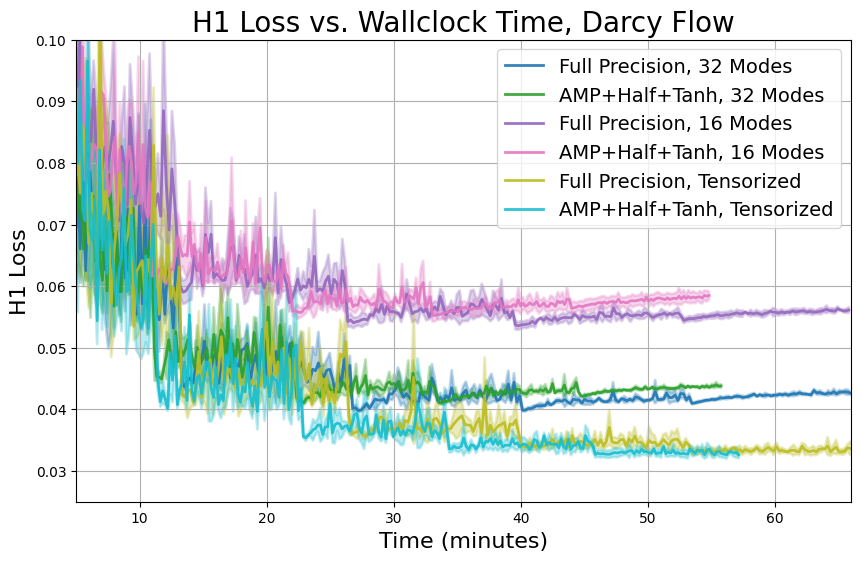

In [7]:
# plot performance vs time for Darcy Flow


plot_training_curves(darcy_data_time, darcy_data_128_h1, darcy_data_128_h1_seed2, 
                     darcy_data_128_h1_seed3, darcy_methods, xlim=[5, 66], ylim=[.025,.1], data="Darcy Flow")

#plot_training_curves(data_time, data_128_h1, data_128_h1_seed2, data_128_h1_seed3, methods)

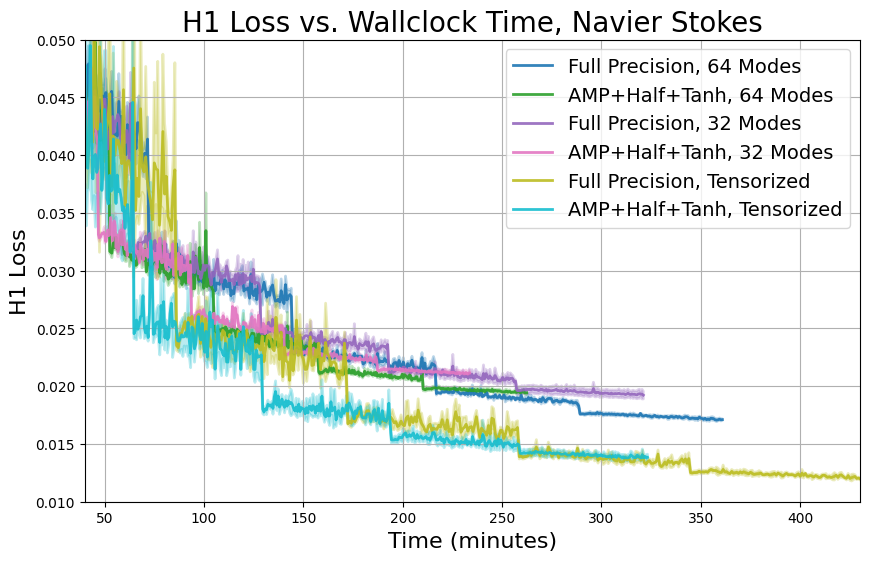

In [8]:
# plot performance vs time for Navier Stokes

plot_training_curves(ns_data_time, ns_data_128_h1, ns_data_128_h1_seed2, 
                     ns_data_128_h1_seed3, ns_methods, xlim=[40, 430], ylim=[.01,.05], data="Navier Stokes")